In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import keras
from keras import layers
import tensorflow as tf
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import random

In [3]:
final_df = pd.read_parquet("/kaggle/input/svarah-indian-english-complete-dataset/combined.parquet")

In [4]:
final_df = final_df[["audio_filepath", "text"]]
final_df.dropna()
final_df.head(3)

,audio_filepath,text
0,{'bytes': b'RIFF|\x9e\x04\x00WAVEfmt \x10\x00\...,"some in the starting, then again I poured and ..."
1,{'bytes': b'RIFF\x02\xae\x02\x00WAVEfmt \x10\x...,"North 24 Parganas, South 24 Parganas, Murshida..."
2,{'bytes': b'RIFF\xd6\x96\x01\x00WAVEfmt \x10\x...,Breast cancers can be classified by different ...


In [5]:
#writing files
os.makedirs("/kaggle/working/sv_audio", exist_ok=True)
for index, row in final_df.iterrows():
    audio_data = row["audio_filepath"]
    
    audio_bytes = audio_data["bytes"]
    file_name = audio_data["path"]
    
    with open(f'sv_audio/{file_name}', "wb") as f:
        f.write(audio_bytes)

In [6]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]
char_to_num = keras.layers.StringLookup(
    vocabulary=characters, oov_token=""
)

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

# Adding Frequency based curriculum learning 
## Benefits
- Learn similar to humans
- Learns frequent words quicker
- Ramps up difficulty over time to prevent model going haywire

In [7]:
import regex as re
from collections import Counter

In [8]:
# Compute Word Frequencies for Curriculum Learning
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z' ]", "", text)  # Keep only letters, spaces, and apostrophes
    return text

all_text = " ".join(final_df["text"].apply(preprocess_text).tolist())
word_counts = Counter(all_text.split())

word_to_freq = {word: freq for word, freq in sorted(word_counts.items(), key=lambda x: x[1], reverse=True)}

def sentence_difficulty(text):
    words = preprocess_text(text).split()
    if not words:
        return 0  
    return sum(1 / (word_to_freq.get(word, 1)) for word in words) / len(words)

In [9]:
final_df = final_df.dropna(subset=["text"])
final_df["difficulty"] = final_df["text"].apply(sentence_difficulty)
final_df.head(3)

,audio_filepath,text,difficulty
0,{'bytes': b'RIFF|\x9e\x04\x00WAVEfmt \x10\x00\...,"some in the starting, then again I poured and ...",0.057883
1,{'bytes': b'RIFF\x02\xae\x02\x00WAVEfmt \x10\x...,"North 24 Parganas, South 24 Parganas, Murshida...",0.418774
2,{'bytes': b'RIFF\xd6\x96\x01\x00WAVEfmt \x10\x...,Breast cancers can be classified by different ...,0.214729


# increase Size of Svarah with modulation for better training results

In [10]:
# Parameters for spectrogram extraction
frame_length = 256
frame_step = 160
fft_length = 384

wavs = "/kaggle/working/sv_audio/"

# -------------------------
# 🛠 **AUGMENTATIONS**
# -------------------------

def add_noise(audio, noise_factor=0.02):
    """Add random Gaussian noise (TensorFlow-based)"""
    noise = tf.random.normal(shape=tf.shape(audio), stddev=noise_factor)
    return audio + noise

def time_stretch_spectrogram(spectrogram, stretch_factor):
    """Apply time stretching directly on the spectrogram using resizing"""
    time_steps, freq_bins = tf.shape(spectrogram)[0], tf.shape(spectrogram)[1]

    # Expand dims to (time_steps, freq_bins, 1) to make it a valid "image"
    spectrogram = tf.expand_dims(spectrogram, axis=-1)  # Shape: (T, F, 1)

    # Compute new time steps
    new_time_steps = tf.cast(tf.round(tf.cast(time_steps, tf.float32) * stretch_factor), tf.int32)

    # Resize spectrogram (bilinear interpolation maintains structure)
    stretched_spectrogram = tf.image.resize(spectrogram, [new_time_steps, freq_bins], method="bilinear")
    stretched_spectrogram = tf.squeeze(stretched_spectrogram)
    
    return stretched_spectrogram

def augment_audio(audio):
    """Apply random augmentations"""
    if tf.random.uniform([]) < 0.5:  # 50% probability
        audio = add_noise(audio)
    return audio

def encode_single_sample(wav_file, label, training=False):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file("/kaggle/working/sv_audio/" + wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)

    # 2️⃣ Apply augmentations 
    if training: 
        audio = augment_audio(audio)

    # 4. Compute STFT
    stft = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(stft)

    # 5. Compute power spectrogram
    power_spectrogram = tf.square(spectrogram)

    sample_rate = 16000
    
    # 6. Compute mel filterbank
    num_mel_bins = 80
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, spectrogram.shape[-1], sample_rate,
        lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrogram = tf.tensordot(power_spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(power_spectrogram.shape[:-1].concatenate([num_mel_bins]))

    # 7. Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # 8. Normalize
    means = tf.math.reduce_mean(log_mel_spectrogram, axis=0, keepdims=True)
    stddevs = tf.math.reduce_std(log_mel_spectrogram, axis=0, keepdims=True)
    log_mel_spectrogram = (log_mel_spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return log_mel_spectrogram, label

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


batch_size = 32

# Split dataset
svtrain_df, svval_df = train_test_split(final_df, test_size=0.2, random_state=42)

# Extract file paths properly
train_audio_paths = svtrain_df["audio_filepath"].apply(lambda x: x["path"]).tolist()
val_audio_paths = svval_df["audio_filepath"].apply(lambda x: x["path"]).tolist()

svtrain_dataset = tf.data.Dataset.from_tensor_slices((train_audio_paths, svtrain_df["text"].tolist()))

svtrain_dataset = (
    svtrain_dataset
    .shuffle(buffer_size=len(svtrain_df))  # Shuffle dataset
    .map(lambda x, y: encode_single_sample(x, y, training=True), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache for performance
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
svvalidation_dataset = tf.data.Dataset.from_tensor_slices((val_audio_paths, svval_df["text"].tolist()))

svvalidation_dataset = (
    svvalidation_dataset
    .map(lambda x, y: encode_single_sample(x, y, training=False), num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)



In [12]:
for s, l in svtrain_dataset.take(1):
    print(s.shape)
    print(l.shape)

(32, 2622, 80)
(32, 232)


- This means that batch size is 32, timesteps is 1774 and 193 we know

# Loading Model

In [13]:
from keras.models import load_model, save_model

In [14]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [15]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [16]:
initial_lr = 1e-6 #start lower to prevent underfitting due to smaller dataset despite augumentations 

#decay so that we reduce it 🤙😝
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.95, staircase=True
)

In [17]:
model = load_model("/kaggle/input/custom-deepspeech/keras/default/1/deepspeechv2_custom.keras", custom_objects={'CTCLoss': CTCLoss})
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=2.0) #initial value was 1e-5
model.compile(optimizer=optimizer, loss=CTCLoss)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 86 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 82 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Optimisers and Callbacks for customing testing and verification purposes

In [18]:
# Beam Search Decoder
def decode_batch_predictions(pred, beam_width=5):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use beam search instead of greedy decoding
    results = tf.keras.backend.ctc_decode(
        pred, input_length=input_len, greedy=False, beam_width=beam_width, top_paths=1
    )[0][0]
    
    # Iterate over the results and decode to text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [19]:
#model checkpoiting (Class to save model and maybe to do some more stuff)
class Checkpointer(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch+1) % 5 == 0: # to prevent saving on epoch 0
            self.model.save("/kaggle/working/svarah_epoch_{}.keras".format(epoch+1))

In [20]:
class CurriculumDataGenerator(keras.utils.Sequence):
   def __init__(self, dataframe, batch_size, num_stages, shuffle=True):
        """
        A dynamic data generator that filters samples based on the current difficulty stage.
        """
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.num_stages = num_stages
        self.shuffle = shuffle
        self.current_stage = 0
        self.epoch_counter = 0  # Track total epochs
        self.filtered_df = self._filter_data()
        self.indices = np.arange(len(self.filtered_df))
        if self.shuffle:
            np.random.shuffle(self.indices)

   def _filter_data(self):
        """Filters training data based on the current curriculum stage."""
        difficulty_threshold = (self.current_stage + 1) / self.num_stages
        return self.dataframe[self.dataframe["difficulty"] <= difficulty_threshold]

   def __len__(self):
        """Defines how many batches per epoch."""
        return int(np.ceil(len(self.filtered_df) / self.batch_size))

   def __getitem__(self, index):
    """Generates one batch of data."""
    batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

    # Handle empty batch issue by getting the next available batch
    if len(batch_indices) == 0:
        return self.__getitem__((index + 1) % len(self))  # Loop to next batch

    batch_df = self.filtered_df.iloc[batch_indices]

    # Load and preprocess audio data
    batch_spectrograms = []
    batch_labels = []
    for _, row in batch_df.iterrows():
        spectrogram, label = encode_single_sample(row["audio_filepath"]["path"], row["text"])
        batch_spectrograms.append(spectrogram)
        batch_labels.append(label)

    # Ensure batch is not empty before converting to tensors
    if len(batch_spectrograms) == 0:
        return self.__getitem__((index + 1) % len(self))  # Try next batch

    # Convert lists to tensors (ensure correct shape)
    batch_spectrograms = tf.keras.preprocessing.sequence.pad_sequences(
        batch_spectrograms, padding="post", dtype="float32"
    )
    batch_labels = tf.keras.preprocessing.sequence.pad_sequences(
        batch_labels, padding="post", dtype="int32"
    )

    return np.array(batch_spectrograms), np.array(batch_labels)


    def on_epoch_end(self):
        self.epoch_counter += 1  # Increase total epoch count
    
        # Update difficulty every 2 epochs until max stage is reached
        if self.epoch_counter % 2 == 0:
            if (self.current_stage + 1) < self.num_stages:
                self.current_stage += 1
                self.filtered_df = self._filter_data()  # Apply new filtering rules
                self.indices = np.arange(len(self.filtered_df))
    
                if self.shuffle:
                    np.random.shuffle(self.indices)
    
                print(f"\n Updating dataset difficulty to Stage {self.current_stage}.")
            else:
                print("\n Maximum difficulty reached. Continuing training at final stage.")


In [21]:
num_curriculum_stages = 50  # Number of difficulty levels

svtrain_generator = CurriculumDataGenerator(final_df, batch_size=32, num_stages=num_curriculum_stages)

In [22]:
history = model.fit(
    svtrain_generator,
    validation_data=svvalidation_dataset,
    epochs=100,
    callbacks=[
        CallbackEval(svvalidation_dataset),
        Checkpointer()
    ]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712

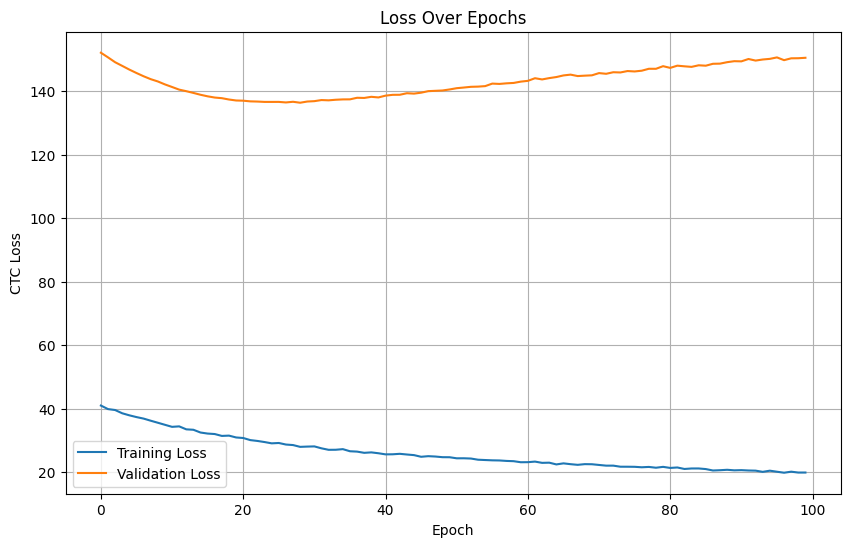

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
model.save("/kaggle/working/deepspeechv2_finetuned_svarah.keras")